In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [2]:
np.random.seed(2022)
iters = 10000

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(2, 32)
        self.linear2 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = self.linear2(x)
        return x  
    
# トレーニング関数
def train(model, optimizer, E, iteration, x, y):
    # 関数ループ
    losses = []
    for i in range(iteration):
        optimizer.zero_grad()                  # 勾配情報を０に初期化
        y_pred = model(x)                      # 予測
        loss = E(y_pred.reshape(y.shape), y)   # 損失を計算
        loss.backward()                        # 勾配の計算
        optimizer.step()                       # 勾配の更新
        losses.append(loss.item())             # 損失値の蓄積
    return model, losses

def test(model, x):
    y_pred = model(x).data.numpy().T[0] #　予測
    return y_pred

# グラフ描画関数
def plot(x, y, x_new, y_pred, losses):
    # ここからグラフ描画-------------------------------------------------
    # グラフの上下左右に目盛線を付ける。
    fig = plt.figure(figsize=(9, 4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
 
    # 軸のラベルを設定する。
    ax1.set_xlabel('φ')
    ax1.set_ylabel('g(φ)')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('E')
 
    # スケール設定
    ax2.set_yscale('log')
 
    # データプロット
    ax1.scatter(x, y, label='dataset')
    ax1.plot(x_new, y_pred, color='red', label='regression', marker="o", markersize=3)
    ax2.plot(np.arange(0, len(losses), 1), losses)
    ax2.text(600, 20, 'Training Error=' + str(round(losses[len(losses)-1], 2)), fontsize=16)
    ax2.text(600, 50, 'Iteration=' + str(round(len(losses), 1)), fontsize=16)
 
    # グラフを表示する。
    ax1.legend()
    fig.tight_layout()
    plt.grid()
    plt.show()
    plt.close()
    # -------------------------------------------------------------------

In [4]:
# トレーニングデータ
x = np.random.uniform(-10, 10, 100)                                   # x軸をランダムで作成
y = x * x                                                    
x = torch.from_numpy(x.astype(np.float32)).float()                  # xをテンソルに変換
y = torch.from_numpy(y.astype(np.float32)).float()                  # yをテンソルに変換
X = torch.stack([torch.ones(100), x], 1)                            # xに切片用の定数1配列を結合

# テストデータ
x_test = np.linspace(-15, 15, 60)                                    # x軸を作成
x_test = torch.from_numpy(x_test.astype(np.float32)).float()        # xをテンソルに変換
X_test = torch.stack([torch.ones(60), x_test], 1)                   # xに切片用の定数1配列を結合

In [5]:
# ネットワークのインスタンスを生成
net = Net()

# 最適化アルゴリズムと損失関数を設定
optimizer = optim.Adam(net.parameters(), lr=0.01)                # 最適化にAdamを設定
E = nn.MSELoss()   

In [6]:
# トレーニング
net, losses = train(model=net, optimizer=optimizer, E=E, iteration=iters, x=X, y=y)

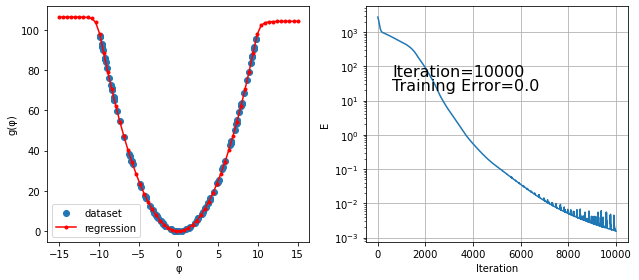

In [7]:
# テスト
y_pred = test(net, X_test)

# グラフ描画
plot(x, y, X_test.data.numpy().T[1], y_pred, losses)

In [8]:
_Vs = np.linspace(-10, 10, 100)
Vs = torch.from_numpy(_Vs.astype(np.float32)).float()
Vs = torch.stack([torch.ones(100), Vs], 1)
extractor = torchvision.models.feature_extraction.create_feature_extractor(net, ["x", "linear1", "tanh", "linear2"])
W1 = net.linear1.weight
W1 = W1.cpu().detach().numpy().copy()
W1 = W1.T
W2 = net.linear2.weight
W2 = W2.cpu().detach().numpy().copy()
W2 = W2.T
U_dashs = []

for V in Vs:
    features = extractor(V)
    H = features["tanh"]
    H = H.cpu().detach().numpy().copy()
    tanh_dash = (1 - H * H)
#     sigmoid_dash = H * (1 - H)
    U_dash = np.dot(tanh_dash * W1, W2)
    U_dashs.append(U_dash[1, 0])

plt.scatter(_Vs, U_dashs, color="g")
plt.xlabel("φ")
plt.ylabel("g'(φ)")
plt.grid()
plt.show()

ValueError: node: 'tanh' is not present in model. Hint: use `get_graph_node_names` to make sure the `return_nodes` you specified are present. It may even be that you need to specify `train_return_nodes` and `eval_return_nodes` separately.